# Agent Executor From Scratch

In this notebook we will create an agent with a search tool. However, at the start we will force the agent to call the search tool (and then let it do whatever it wants after). This is useful when you want to force agents to call particular tools, but still want flexibility of what happens after that.

This examples builds off the base agent executor. It is highly recommended you learn about that executor before going through this notebook. You can find documentation for that example [here](./base.ipynb).

Any modifications of that example are called below with **MODIFICATION**, so if you are looking for the differences you can just search for that.

## Setup

First we need to install the packages required

In [4]:
%pip install --quiet -U langgraph langchain langchain_openai tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 717.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 3.0 MB/s eta 0:00:00


Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [5]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [6]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## Create the LangChain agent

First, we will create the LangChain agent. For more information on LangChain agents, see [this documentation](https://python.langchain.com/v0.2/docs/concepts/#agents)

In [7]:
!pip install -q langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.3 MB/s eta 0:00:00


In [9]:
!pip install -q langchainhub

In [10]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai.chat_models import ChatOpenAI

tools = [TavilySearchResults(max_results=1)]

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-functions-agent")

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", streaming=True)

# Construct the OpenAI Functions agent
agent_runnable = create_openai_functions_agent(llm, tools, prompt)

## Define the graph state

We now define the graph state. The state for the traditional LangChain agent has a few attributes:

1. `input`: This is the input string representing the main ask from the user, passed in as input.
2. `chat_history`: This is any previous conversation messages, also passed in as input.
3. `intermediate_steps`: This is list of actions and corresponding observations that the agent takes over time. This is updated each iteration of the agent.
4. `agent_outcome`: This is the response from the agent, either an AgentAction or AgentFinish. The AgentExecutor should finish when this is an AgentFinish, otherwise it should call the requested tools.


In [11]:
import operator
from typing import Annotated, TypedDict, Union

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    # The input string
    input: str
    # The list of previous messages in the conversation
    chat_history: list[BaseMessage]
    # The outcome of a given call to the agent
    # Needs `None` as a valid type, since this is what this will start as
    agent_outcome: Union[AgentAction, AgentFinish, None]
    # List of actions and corresponding observations
    # Here we annotate this with `operator.add` to indicate that operations to
    # this state should be ADDED to the existing values (not overwrite it)
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [12]:
from langchain_core.agents import AgentFinish

from langgraph.prebuilt.tool_executor import ToolExecutor

# This a helper class we have that is useful for running tools
# It takes in an agent action and calls that tool and returns the result
tool_executor = ToolExecutor(tools)


# Define the agent
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}


# Define the function to execute tools
def execute_tools(data):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_action = data["agent_outcome"]
    output = tool_executor.invoke(agent_action)
    return {"intermediate_steps": [(agent_action, str(output))]}


# Define logic that will be used to determine which conditional edge to go down
def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if isinstance(data["agent_outcome"], AgentFinish):
        return "end"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        return "continue"

**MODIFICATION**

Here we create a node that returns an AgentAction that just calls the Tavily search with the input

In [13]:
tools[0].name

'tavily_search_results_json'

In [14]:
from langchain_core.agents import AgentActionMessageLog


def first_agent(inputs):
    action = AgentActionMessageLog(
        # We force call this tool
        tool="tavily_search_results_json",
        # We just pass in the `input` key to this tool
        tool_input=inputs["input"],
        log="",
        message_log=[],
    )
    return {"agent_outcome": action}

## Define the graph

We can now put it all together and define the graph!

**MODIFICATION**

We now add a new `first_agent` node which we set as the entrypoint.

In [15]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)
workflow.add_node("first_agent", first_agent)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "first_agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After the first agent, we want to take an action
workflow.add_edge("first_agent", "action")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

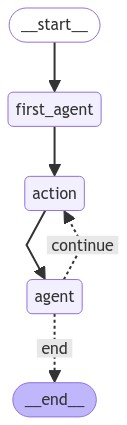

In [16]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
inputs = {"input": "what is the weather in San Jeronimo de Tunan, Huancayo, Peru", "chat_history": []}
for s in app.stream(inputs):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentActionMessageLog(tool='tavily_search_results_json', tool_input='what is the weather in San Jeronimo de Tunan, Huancayo, Peru', log='', message_log=[])}
----
{'intermediate_steps': [(AgentActionMessageLog(tool='tavily_search_results_json', tool_input='what is the weather in San Jeronimo de Tunan, Huancayo, Peru', log='', message_log=[]), '[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Jeronimo De Tunan\', \'region\': \'Junin\', \'country\': \'Peru\', \'lat\': -11.95, \'lon\': -75.25, \'tz_id\': \'America/Lima\', \'localtime_epoch\': 1721746432, \'localtime\': \'2024-07-23 9:53\'}, \'current\': {\'last_updated_epoch\': 1721745900, \'last_updated\': \'2024-07-23 09:45\', \'temp_c\': 8.3, \'temp_f\': 47.0, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, \'wind_degree\': 194, \'wind_dir\': \'SSW\', \'pressu